In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

from neuralnetlib.preprocessing import MinMaxScaler
from neuralnetlib.models import Sequential, GAN
from neuralnetlib.layers import Input, Dense, BatchNormalization, Dropout, Activation
from neuralnetlib.activations import LeakyReLU
from neuralnetlib.optimizers import Adam
from neuralnetlib.losses import Wasserstein

In [2]:
print("Loading MNIST dataset...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X.astype('float32')

Loading MNIST dataset...


C:\Users\marcp\AppData\Roaming\Python\Python310\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
dim = X.shape[1]

scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)
X_reshaped = X_scaled.reshape(-1, dim)

latent_dim = 100

In [4]:
generator = Sequential(random_state=42)

generator.add(Input(latent_dim))

generator.add(Dense(256))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(alpha=0.2)))

generator.add(Dense(512))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(alpha=0.2)))

generator.add(Dense(1024))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(alpha=0.2)))

generator.add(Dense(dim, activation='tanh'))

In [5]:
discriminator = Sequential(random_state=42)

discriminator.add(Input(dim))

discriminator.add(Dense(128, input_dim=dim))
discriminator.add(Activation(LeakyReLU(alpha=0.4)))
discriminator.add(Dropout(0.6))

discriminator.add(Dense(64))
discriminator.add(Activation(LeakyReLU(alpha=0.4)))
discriminator.add(Dropout(0.6))

discriminator.add(Dense(1, activation='linear'))

In [6]:
gan = GAN(latent_dim=latent_dim)

gan.compile(
    generator,
    discriminator,
    generator_optimizer=Adam(learning_rate=0.001),
    discriminator_optimizer=Adam(learning_rate=0.0001),
    loss_function='wass',
    verbose=True
)

GAN(latent_dim=100, gradient_clip_threshold=0.1, enable_padding=False, padding_size=32, random_state=1732530033929823500)
-------------------------------------------------
Generator:
Sequential(gradient_clip_threshold=5.0, enable_padding=False, padding_size=32, random_state=42)
-------------------------------------------------
Layer 1: Input(input_shape=(100,))
Layer 2: Dense(units=256)
Layer 3: BatchNormalization(momentum=0.9, epsilon=1e-05)
Layer 4: Activation(LeakyReLU)
Layer 5: Dense(units=512)
Layer 6: BatchNormalization(momentum=0.9, epsilon=1e-05)
Layer 7: Activation(LeakyReLU)
Layer 8: Dense(units=1024)
Layer 9: BatchNormalization(momentum=0.9, epsilon=1e-05)
Layer 10: Activation(LeakyReLU)
Layer 11: Dense(units=784)
Layer 12: Activation(Tanh)
-------------------------------------------------
Loss function: Wasserstein
Optimizer: Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, clip_norm=None, clip_value=None)
-------------------------------------------------


In [7]:
epochs = 100
batch_size = 128
save_interval = 10

history = gan.fit(
    X_reshaped,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True,
    metrics=['mmd']
)

[==============----------------] 48% Epoch 1/100 - d_loss: 24.2674 - g_loss: -5.5180 - mmd: 0.0183 - 42.36s08ss.45ss4s.89s7s

KeyboardInterrupt: 

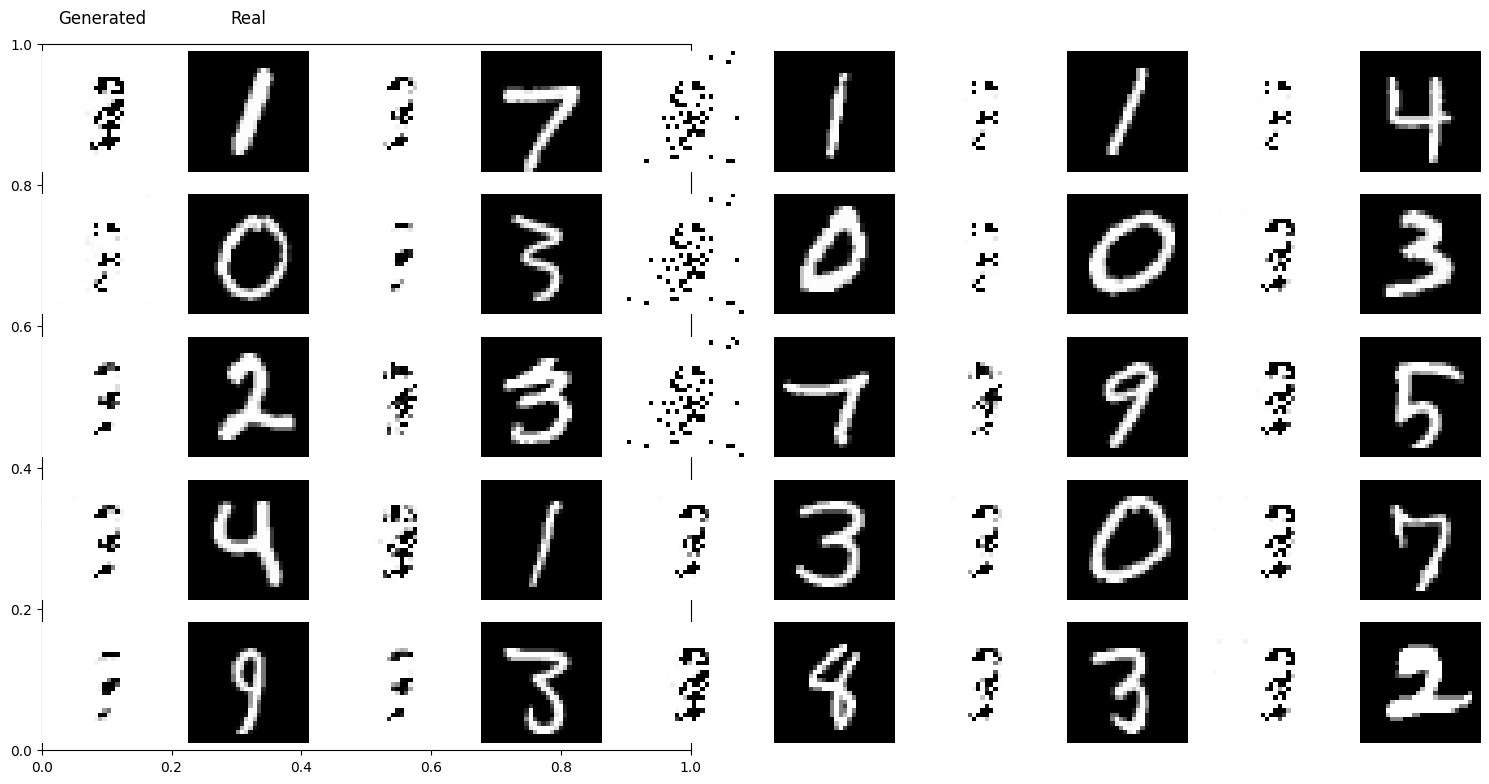

NameError: name 'history' is not defined

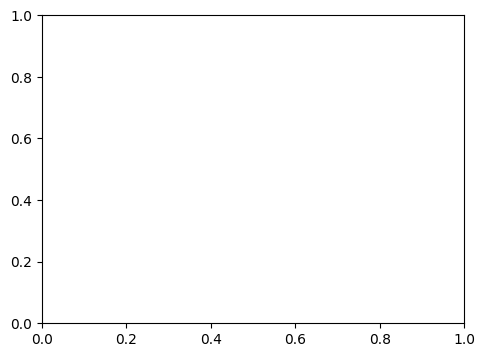

In [8]:
def visualize_mnist_samples(gan_model, n_samples=25, n_cols=5):
    n_rows = n_samples // n_cols
    plt.figure(figsize=(15, 8))

    generated_samples = gan_model.predict(n_samples)
    
    generated_samples = (generated_samples + 1) / 2
    
    rng = np.random.default_rng(42)
    real_indices = rng.integers(0, X_reshaped.shape[0], n_samples)
    real_samples = (X_reshaped[real_indices] + 1) / 2

    plt.subplot(1, 2, 1)
    for idx in range(n_samples):
        plt.subplot(n_rows, n_cols*2, idx*2 + 1)
        plt.imshow(generated_samples[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if idx % n_cols == 0:
            if idx == 0:
                plt.title('Generated', pad=20)
        
        plt.subplot(n_rows, n_cols*2, idx*2 + 2)
        plt.imshow(real_samples[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if idx % n_cols == 0:
            if idx == 0:
                plt.title('Real', pad=20)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['discriminator_loss'], label='Discriminateur')
    plt.plot(history['generator_loss'], label='Générateur')
    plt.title('Loss evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['mmd'], label='MMD Score')
    plt.title('MMD Score evolution')
    plt.xlabel('Epoch')
    plt.ylabel('MMD')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

visualize_mnist_samples(gan)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history['discriminator_loss'], label='Discriminator Loss')
plt.plot(history['generator_loss'], label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('gan_training_history.png')
plt.close()

print("Saving model...")
gan.save('mnist_gan_model')